# 3REQ system

Requirement analysis system.

In [227]:
from docx2python import docx2python
import os

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

In [228]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Step 1: List the documents's sections with "latency"

In the first step, we go through the documents in the folder "input_standards" and we extract which sections of these documents contain th word "latency". We store the results in a dictionary.

In [229]:
def extractLatencySections(doc):
    strSectionTitle = ""
    dictSections = {}
    listLatency = []

    doc_result = docx2python(doc,paragraph_styles = True, html=True)

    # we iterate over all lines
    # look for the section titles (which have the tag <h1>, <h2>, <h3>, etc.)
    # then we add the content of each section to the dictionary
    # and if there is a word "latency" somewhere in the section, we add the section title to the listLatency
    for oneLine in doc_result.text.split('\n'):
        if "<h" in oneLine:
            strSectionTitle = oneLine
            dictSections[strSectionTitle] = []

        if strSectionTitle != "":  
            dictSections[strSectionTitle].append(oneLine)

        if "latency" in oneLine: 
            listLatency.append(strSectionTitle)
            
    # remove the keys from the dictionary if they are not part of the listLatency
    # as we want to get only the relevant sections, i.e., the one with the word latency
    for key in list(dictSections.keys()):
        if key not in listLatency:
            del dictSections[key]

    # return the dictionary with the relevant sections
    return dictSections


In [230]:
docInputFolder = "./input_standards"

# this is the return list of all the lines in the document
lstAllLines = []

# for each .docx file in the input folder
# extract the sections with latency using the extractLatencySections function
# and print the sections
for doc in os.listdir(docInputFolder):    

    if doc.endswith(".docx"):

        # since things can go wrong with the latency library, 
        # we use a try except block to avoid the program to stop
        try: 
            dictSections = extractLatencySections(os.path.join(docInputFolder, doc))
        
            # we list the content
            # as a long list of sections 
            for key in dictSections:

                lstOneLine = [key, doc]

                for line in dictSections[key]:
                    lstOneLine.append(line)
                    
                lstAllLines.append(lstOneLine)

        except Exception as e:
            print(f"Error with {doc}: {e}")

In [231]:
model = SentenceTransformer("all-MiniLM-L6-v2")

# list with all embeddings for the sections
lstEmbeddings = []

for oneLine in lstAllLines:

    # the content of the section starts on the third position of the list
    sentences = oneLine[3:]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, avg_embedding]

    lstEmbeddings.append(lstOneLine)


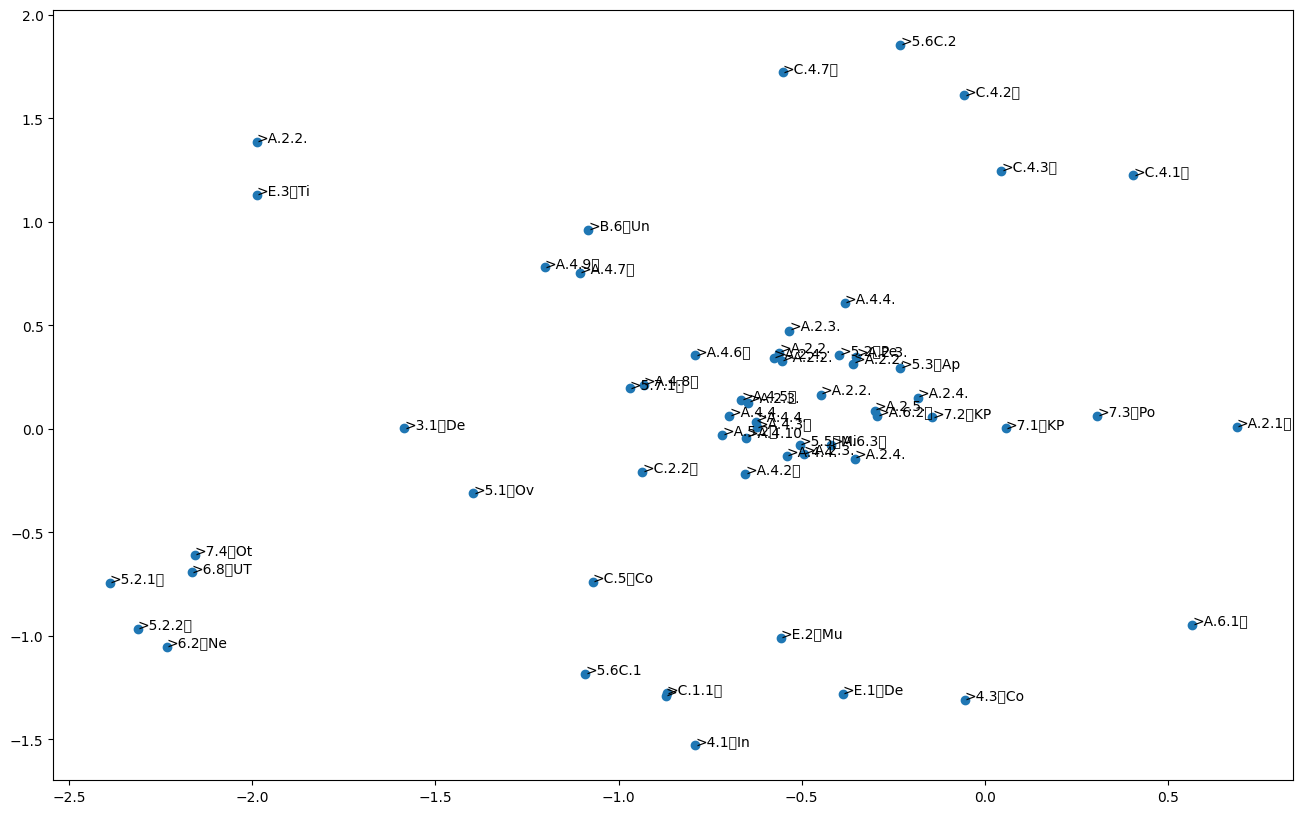

In [232]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[3] for x in lstEmbeddings])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1])

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddings]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[3:10])


plt.show()

## Step 2: Find the relevant sections

In this step, we take the sections identified in Step 1 and we compare them to a list of right and wrong requirements. The list is stored in the file List.xlsx

In [233]:
# open the file List.xlsx using pandas
# and read the workshop NR
df = pd.read_excel("List.xlsx", sheet_name="R_NR")

# convert the dataframe to a list of lists
lstReference = df.values.tolist()

lstReference[0]

['The 5G system shall support an end-to-end latency of less than 5 ms or 10 ms, as requested by the UE initiating the communication.',
 1]

In [234]:
# list with all embeddings for the sections
lstEmbeddingsRef = []

for oneLine in lstReference:

    # the content of the section starts on the third position of the list
    sentences = oneLine[0]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embedding = embeddings
    
    lstOneLine = [oneLine[0], 'REF', oneLine[1], avg_embedding]

    lstEmbeddingsRef.append(lstOneLine)

In [238]:
# concatenate the two lists
lstEmbeddingsAll = lstEmbeddings + lstEmbeddingsRef

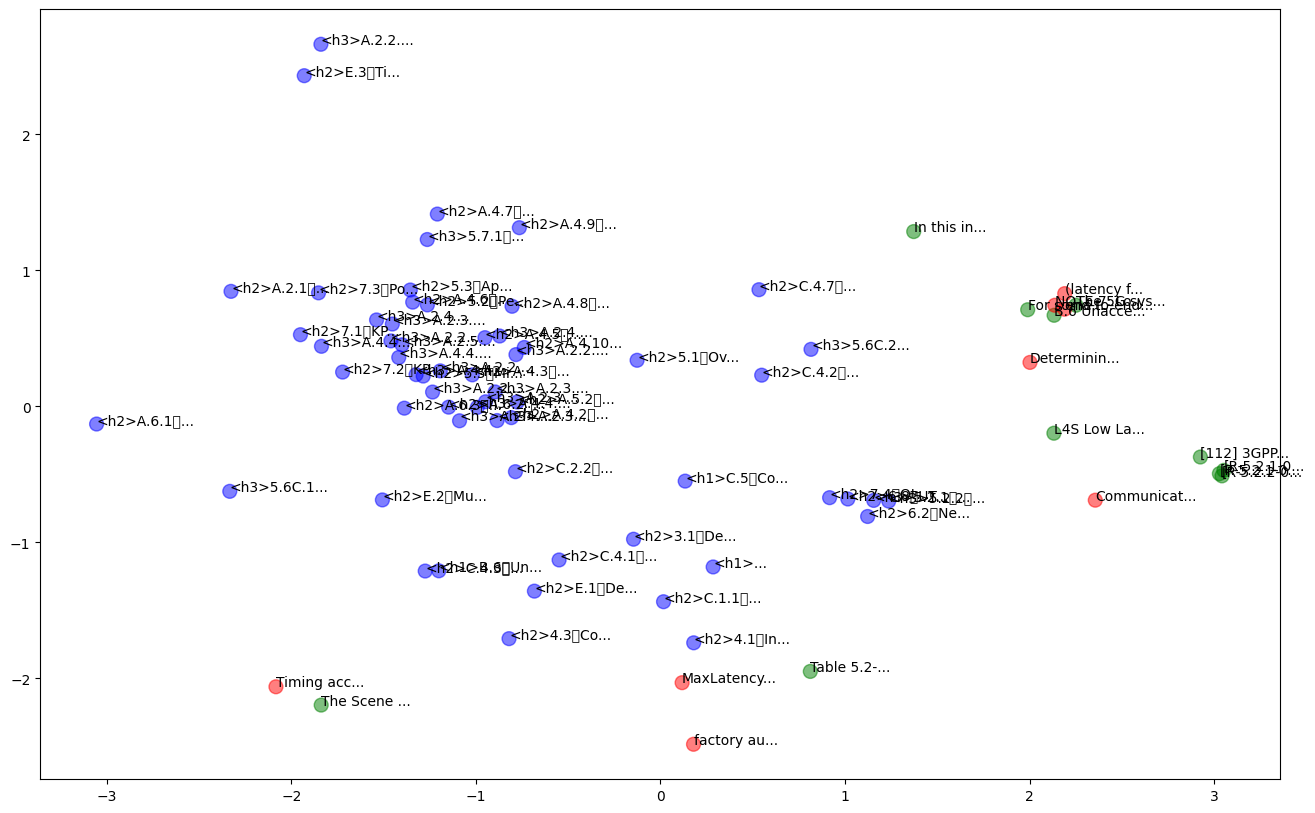

In [236]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[3] for x in lstEmbeddingsAll])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# Create a color map based on x[2]
color_map = {0: 'red', 1: 'green', 2: 'blue'}
colors = [color_map[x[2]] for x in lstEmbeddingsAll]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1],c=colors, s=100, alpha=0.5)

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddingsAll]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[:10]+'...')


plt.show()

In [237]:
from sklearn.metrics.pairwise import euclidean_distances

# for each line in lstEmbeddings
# we calculate the euclidean distance with each line in lstEmbeddingsRef

lstDistPos = []
lstDistNeg = []

for oneLine in lstEmbeddings:    
    for oneLineRef in lstEmbeddingsRef:
        if oneLineRef[2] == 1:
            # euclidean distance between the two embeddings
            dist = euclidean_distances([oneLine[3]], [oneLineRef[3]])
            lstDistPos.append(dist[0][0])
        if oneLineRef[2] == 0:
            # euclidean distance between the two embeddings
            dist = euclidean_distances([oneLine[3]], [oneLineRef[3]])
            lstDistNeg.append(dist[0][0])
    
    # now calculate the average for both lists
    avgDistPos = np.mean(lstDistPos)
    avgDistNeg = np.mean(lstDistNeg)

    if avgDistPos < avgDistNeg:
        print(f"Section {oneLine[0]} is relevant")
    else:
        print(f"Section {oneLine[0]} is not relevant")
                

Section <h1> is relevant
Section <h2>3.1	Definitions</h2> is not relevant
Section <h2>4.1	Introduction</h2> is not relevant
Section <h2>4.3	Communication attributes</h2> is not relevant
Section <h2>5.1	Overview</h2> is not relevant
Section <h2>5.2	Periodic deterministic communication</h2> is not relevant
Section <h2>5.3	Aperiodic deterministic communication</h2> is relevant
Section <h2>5.5	Mixed traffic</h2> is relevant
Section <h3>5.6C.1	Description</h3> is relevant
Section <h3>5.6C.2	Requirements</h3> is relevant
Section <h3>5.7.1	General requirements</h3> is relevant
Section <h2>A.2.1	Overview</h2> is relevant
Section <h3>A.2.2.1	Motion control</h3> is relevant
Section <h3>A.2.2.2	Control-to-control communication</h3> is relevant
Section <h3>A.2.2.3	Mobile robots</h3> is relevant
Section <h3>A.2.2.4	Wired to wireless link replacement</h3> is relevant
Section <h3>A.2.2.5	Cooperative carrying</h3> is relevant
Section <h3>A.2.3.1	Closed-loop control</h3> is relevant
Section <h3>A.2.3.2

## Step 3: Find which requirements are impacted

In this step, we compare the relevant sections with the existing requirements. Based on the distance, we can determine which requirements are impacted. The requirements are provided as a separete list. 

## Step 4: Find if it is a new requirement

In the last step, we look at the distances and then we find if they too far away from the existing requirements. If they are, we can consider them as new requirements.